In [2]:
import numpy as np
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt
import sys
import os
from filterpy.monte_carlo import systematic_resample
import scipy as sp
from scipy import stats

PROJECT_ROOT = os.path.abspath(os.path.join(
                  os.path.dirname('utils'), 
                  os.pardir)
)
sys.path.append(PROJECT_ROOT)
from filterscripts import distance_map
%matplotlib inline

c:\Users\mso\Anaconda3\envs\car\lib\site-packages\_distutils_hack\__init__.py:30: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


## Load Distance Map

In [3]:
dm = distance_map.DistanceMap(1, 100, 'road_points_data_test')

Converted Points (135, 2)
(2195, 2340)


## Function to create Uniform Particles

In [4]:
from numpy.random import uniform

def create_uniform_particles(x_range, y_range, x_dot_range, y_dot_range,x_ddot_range, y_ddot_range, theta_range, delta_range,N):
    particles = np.empty((N, 8))
    particles[:, 0] = uniform(x_range[0], x_range[1], size=N)
    particles[:, 1] = uniform(y_range[0], y_range[1], size=N)
    particles[:, 2] = uniform(x_dot_range[0], x_dot_range[1], size=N)
    particles[:, 3] = uniform(y_dot_range[0], y_dot_range[1], size=N)
    particles[:, 4] = uniform(x_ddot_range[0], x_ddot_range[1], size=N)
    particles[:, 5] = uniform(y_ddot_range[0], y_ddot_range[1], size=N)    
    particles[:, 6] = uniform(theta_range[0], theta_range[1], size=N)
    particles[:, 7] = uniform(delta_range[0], delta_range[1], size=N)
    particles[:, 6] %= 2 * np.pi
    particles[:, 7] %= 2 * np.pi
    return particles

## Recreation of the model
We have our state: 

$\vec x = \begin{bmatrix} x, y, \dot x, \dot y, \ddot x , \ddot y, \theta, \delta \end{bmatrix}^T$

And we have our control input: 
$\vec u = \begin{bmatrix} \ddot x_u, \ddot y_u, \varphi \end{bmatrix}$ 

We also have our measurements: 
$\vec z = \begin{bmatrix} \ddot x_z, \ddot y_z, \theta \end{bmatrix}$ 

The state transfer function does the following calculation: 

$$
\vec x_{t+1} = 
\begin{bmatrix} x_{t+1}\\ y_{t+1}\\ \dot x_{t+1}\\
\dot y_{t+1}\\
\ddot x_{t+1}\\
\ddot y_{t+1} \\
\theta_{t+1} \\ 
\delta_{t+1} \\
\end{bmatrix}
=
\begin{bmatrix} 
x_t + v\cos(\theta_t + \delta_t)  \Delta t\\ 
y_t + v\sin(\theta_t + \delta_t)  \Delta t\\ 
\dot x_t + \ddot x_{t} \Delta t\\ 
\dot y_t + \ddot y_{t} \Delta t\\
%\ddot x_t + \dddot x_t \Delta t \\ 
%\ddot y_t + \dddot y_t \Delta t\\ 
\ddot x_{u_t}\\
\ddot y_{u_t}\\
\theta_t + \frac{v\sin(\delta)}{L} \Delta t\\ 
\delta + \varphi \Delta t
\end{bmatrix}$$

In [5]:
# x = x-0,y-1,x_dot-2, y_dot-3, x_ddot-4, y_ddot-5, theta-6, delta-7
# u = acc_x, acc_y, steering 
def F(x, u, step, L): 
    # calculate nect velocity
    x_dot_next = x[2] + (x[4] * step)
    y_dot_next = x[3] + (x[5] * step)
    # control input as next acceleration
    x_ddot_next = u[0]
    y_ddot_next = u[1]
    # calculate velocity scalar
    velocity = np.linalg.norm((x[2], x[3]))
    # get next position
    x_next = x[0] + (velocity*np.cos(x[6] + x[7]) * step)
    y_next = x[1] + (velocity*np.sin(x[6] + x[7]) * step)
    #calculate theta and delta
    theta_next = x[6] + (((velocity*np.sin(x[7]))/L) * step)
    delta_next = x[7] + (u[2] * step)
    
    
    return np.array([x_next, y_next,x_dot_next, y_dot_next, x_ddot_next, y_ddot_next, theta_next, delta_next], dtype=object) 

## Create Particle Filter

In [6]:
def predict(particles, u, std, dt, L): 
    N = len(particles) 
    # Needs noise: not in a for loop
    for i in range(len(particles)): 
        particles[i] = F(particles[i], u, dt, L)

def update(particles, weights,z, R, distance_map):
    for i, particle in enumerate(particles):
        pi = dm.coord_to_image(particle[0:2])
        if (pi[0] < dm.distance_map.shape[1] and pi[0] > 0 and pi[1] < dm.distance_map.shape[0] and pi[1] > 0): 
            distance_to_next_road = dm.distance_map[pi[1], pi[0]]# y,x
            #rotation_difference = abs((abs(particle[6]-z[2])+180) %360 - 180)# index 6 = theta
            #acceleration_difference = np.linalg.norm(abs(z[0:2] - particle[4:5]))
            #average_distance = (acceleration_difference + rotation_difference + distance_to_next_road) / 3
            weights *= sp.stats.norm(distance_to_next_road, R).pdf(distance_to_next_road)
            print(weights.shape)
            '''
            road_distance = dm.distance_map[pi[1], pi[0]]# y,x
            rotation_difference = abs((abs(particle[6]-z[2])+180) %360 - 180)# index 6 = theta
            acceleration_difference = np.linalg.norm(abs(z[0:2] - particle[4:5]))
            average_distance = (acceleration_difference + rotation_difference + road_distance) / 3
            weights[i] = average_distance
            '''
        else:    
            weights[i] = 0
                
    weights += 1.e-300
    weights /= sum(weights) # normalize
    #print(weights)

    
def estimate(particles, weights): 
    pos = particles[:,0:2]
    mean = np.average(pos, weights=weights, axis=0)
    var  = np.average((pos - mean)**2, weights=weights, axis=0)
    return mean, var


def resample_from_index(particles, weights, indexes):
    particles[:] = particles[indexes]
    weights.resize(len(particles))
    weights.fill (1.0 / len(weights))
    
def neff(weights):
    return 1. / np.sum(np.square(weights))

## Load and Prepare Data

In [7]:
def get_rotation_matrix(theta): 
    return np.array([[np.cos(theta), np.sin(theta)], [-np.sin(theta), np.cos(theta)]])

In [8]:
simulation_data = pd.read_csv("../data/Sim_data_known.csv")
local_acc = np.stack((simulation_data['accelerometer_x'], simulation_data['accelerometer_y']), axis = 1)

matrices = []
for o in simulation_data['orientations'].values: 
    matrices.append(get_rotation_matrix(o))
matrices = np.array(matrices)

global_acc = []
for i in range(len(matrices)): 
    global_acc.append(np.dot(local_acc[i], matrices[i]))
global_acc = np.array(global_acc)
simulation_data['accelerometer_x'] = global_acc[:, 0]
simulation_data['accelerometer_y'] = global_acc[:, 1]


In [9]:
simulation_data.head()

,Unnamed: 0,accelerometer_x,accelerometer_y,accelerometer_z,gyroscope_x,gyroscope_y,gyroscope_z,orientations,velocity_x,velocity_y,acc_x,acc_y,steering,throttle,positions_x,positions_y,timestamps
0,0,-0.019171,-0.011027,9.809976,0.022369,-0.018046,-0.000051,3.147147,-0.003209,-0.011690,0.085666,-0.305657,-1.817319,0.0,74.799454,28.343596,90.996641
1,1,64909.811146,24802.238060,302.282562,-0.004640,0.003459,0.000010,3.147144,0.000592,0.001789,0.014291,0.052912,0.694869,0.0,74.799568,28.343523,91.107473
2,2,0.354885,-0.048670,8.555722,-0.005536,0.004612,0.000009,3.147148,0.000784,0.002766,-0.002324,-0.006155,0.699206,0.0,74.799393,28.343491,91.221977
3,3,-0.082266,-0.034675,-11.976091,-0.003668,0.003063,0.000005,3.147149,0.000519,0.001925,-0.003278,-0.010839,0.706839,0.0,74.799278,28.343491,91.304454
4,4,-0.064038,-0.008370,3.197480,-0.001937,0.001566,0.000002,3.147150,0.000265,0.001043,-0.002358,-0.008394,0.694879,0.0,74.799217,28.343496,91.397319


Invert the Y-Axis 

In [10]:
simulation_data['positions_y'] = -simulation_data['positions_y']
simulation_data['acc_y'] = -simulation_data['acc_y']
simulation_data['accelerometer_y'] = -simulation_data['accelerometer_y']
simulation_data['velocity_y'] = -simulation_data['velocity_y']

In [11]:
def plot_particles_and_mean(particles, weights, mu, ground_truth): 
    # convert and plot the particles 
    converted_particles = []
    plt.imshow(dm.distance_map, cmap="gray")
    for i, rp in enumerate(particles): 
        converted_particle = dm.coord_to_image(np.array([rp[0], rp[1]]))
        plt.scatter(converted_particle[0], converted_particle[1], s=weights[i]*500, c='blue')
    converted_particles = np.array(converted_particles)
    
    #convert and plot mean
    mean = dm.coord_to_image(mu)
    plt.plot(mean[0], mean[1], 'ro')
    
    #convert and plot ground truth
    converted_gt = dm.coord_to_image(ground_truth)
    
    plt.scatter(converted_gt[0],converted_gt[1], c="green")

    plt.ylim([2500, 0])
    plt.xlim([0, 2500])
    plt.show()

## First test with real data

In [12]:
ground_truth = np.stack([simulation_data['positions_x'], simulation_data['positions_y']], axis=1)
zs = np.stack([simulation_data['accelerometer_x'], simulation_data['accelerometer_y'], simulation_data['orientations']], axis=1)
us = np.stack([simulation_data['acc_x'], simulation_data['acc_y'], simulation_data['steering'].values], axis=1)


seconds = 60
dt = 1/10
Ts=simulation_data['timestamps'].values
xs = []
L = 1.8
N = 1000

x_min = dm.road_points[:,0].min()
x_max = dm.road_points[:,0].max()

y_min = dm.road_points[:,1].min()
y_max = dm.road_points[:,1].max()


x_range = [x_min, x_max]
y_range = [y_min, y_max]
x_dot_range = [0, 10]
y_dot_range = [0, 10]
x_ddot_range = [0, 10]
y_ddot_range = [0, 10]

theta_range = [0,2*np.pi]
delta_range = [-np.pi/2, np.pi/2]
particles = create_uniform_particles(x_range, y_range, x_dot_range, y_dot_range,x_ddot_range, y_ddot_range, theta_range, delta_range, N)
weights = np.full((particles.shape[0],), 1/particles.shape[0])

shall_plot = True

for i,u in enumerate(Ts): 
    predict(particles, us[i], 0.02, Ts[i] - Ts[i-1], L)
    
    update(particles, weights,zs[i], 0, dm.distance_map)
    
    if (neff(weights) < N/2): 
        print("resampled")
        indexes = systematic_resample(weights)
        resample_from_index(particles, weights, indexes)
        assert np.allclose(weights, 1/N)
    
    mu, var = estimate(particles,weights)
    if (i % 10 == 0): 
        plot_particles_and_mean(particles, weights, mu, ground_truth[i])
 
    xs.append(mu)
xs = np.array(xs)


c:\Users\mso\Anaconda3\envs\car\lib\site-packages\scipy\stats\_distn_infrastructure.py:1870: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)


ValueError: need at least one array to concatenate

<Figure size 432x288 with 1 Axes>

(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)


ValueError: need at least one array to concatenate

<Figure size 432x288 with 1 Axes>

(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)


ValueError: need at least one array to concatenate

<Figure size 432x288 with 1 Axes>

(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)

## Plot particles
Legends will be added later: 
- blue = particles
- red = mean
- yellow = ground truth

In [37]:
xs_image_coord = []
for x in xs: 
    xs_image_coord.append(dm.coord_to_image(x))
xs_image_coord = np.array(xs_image_coord)

gt_image_coord = []
for gt in ground_truth: 
    gt_image_coord.append(dm.coord_to_image(gt))
gt_image_coord = np.array(gt_image_coord)

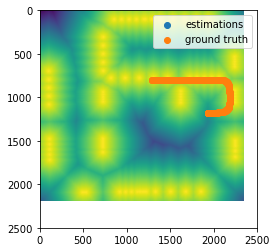

In [40]:
plt.imshow(dm.distance_map)
plt.scatter(xs_image_coord[:,0], xs_image_coord[:,1], label="estimations")
plt.scatter(gt_image_coord[:,0],gt_image_coord[:,1], label="ground truth")
plt.ylim([2500, 0])
plt.xlim([0, 2500])
plt.legend()
plt.show()

In [72]:
converted_particles = []
for rp in particles: 
    converted_particles.append(dm.coord_to_image(np.array([rp[0], rp[1]])))
converted_particles = np.array(converted_particles)

In [76]:
for i, x in enumerate(xs): 
    xs[i] = dm.coord_to_image(x)

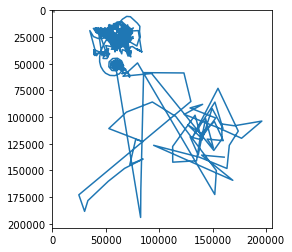

In [77]:
plt.imshow(dm.distance_map, cmap="gray")

#plt.scatter(converted_particles[:,0], converted_particles[:,1])
plt.plot(xs[:,0], xs[:,1])
plt.show()

In [118]:
np.delete(particles,1)

array([  89.87601539,    5.0498498 ,    7.04957677,    6.21794897,
          1.45478145, -105.70230154,   43.13096862,    3.80378066,
          1.87258304,    5.86148025,    4.88933962,   98.39890965,
         29.8924621 ,    3.16951098,    8.8262027 ,    0.19607461,
          1.14164864,  -80.00001231,   33.76801197,    1.77112524,
          8.77728219,    2.97334356,    1.22797221,  -22.65526556,
         48.4184837 ,    4.11103464,    8.87715832,    5.41262946,
          0.51397297,  -97.16700096,   18.15731864,    9.01514783,
          9.42057396,    5.59581735,    4.88502452,  -60.94060905,
        -19.00678056,    2.78089541,    0.88077057,    0.68754409,
          4.77713649,   75.65490949,  -21.77465498,    4.0160926 ,
          5.7925454 ,    3.07008927,    1.10135832,   68.05551041,
         -7.93227455,    0.9160211 ,    1.9939821 ,    5.21538   ,
          4.84651794,  -60.40711443,  -19.72959774,    9.64086559,
          2.04230472,    2.83494334,    5.23008751])

In [80]:
len(dm.distance_map)

2195

In [81]:
a = 10
b = 360
print(abs((abs(a-b)+180) %360 - 180))

10


In [74]:
630 % 360 -180


90